In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simulator import LVsimulator, LVobserver
%load_ext autoreload
%autoreload 2

## Theory

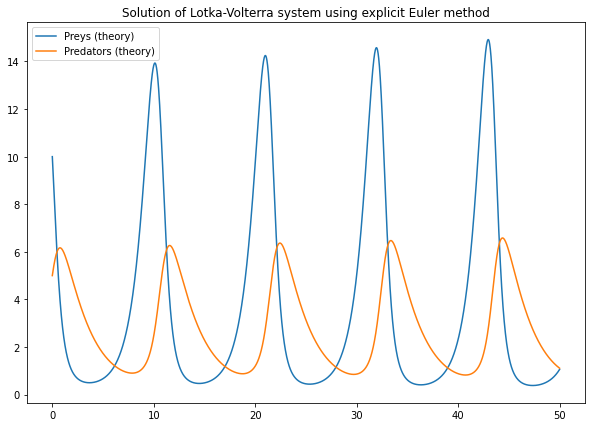

In [2]:
tmax=50
tres=100
t = np.linspace(0,tmax,tmax*tres+1)

# True values
alpha, beta, gamma, delta = 1.1, 0.4, 0.4, 0.1
R0, F0 = 10, 5
#alpha, beta, gamma, delta = 2/3.,4/3.,1,1
#R0, F0 = 1.8, 1.8

# Define simulator instance
LVt = LVsimulator(R0, F0, alpha, beta, gamma, delta)

# Solve the ODEs
Rtheory, Ftheory = LVt.EEuler(t)

# Plot the solution
plt.figure(figsize=(10,7))
plt.plot(t,Rtheory,label="Preys (theory)")
plt.plot(t,Ftheory,label="Predators (theory)")
plt.legend(loc="best")
plt.title("Solution of Lotka-Volterra system using explicit Euler method") 
plt.show()

## Signal and observed data

In [3]:
# Simulate true data
Rtrue=np.array([Rtheory[tres*n] for n in range(tmax)])
Ftrue=np.array([Ftheory[tres*n] for n in range(tmax)])

# Define a mask
masks=[np.array([4, 5, 6]), np.array([19, 20]), np.array([35, 36, 37])]
mask=np.array([1 if n in np.concatenate(masks) else 0 for n in range(tmax)])

# Define observer instance and simulate observed data
LVo = LVobserver(Rtrue, Ftrue, R0=R0, F0=F0)
LVo.observe(threshold=12, mask=mask, P=0.08, Q=0.05, R=0.05, S=0.005, T=5)
Robs, Rdata, Fobs, Fdata = LVo.Robs, LVo.Rdata, LVo.Fobs, LVo.Fdata

In [4]:
# Check the model for the signal
Rtsignal, Ftsignal = LVo.signal(Rtrue, Ftrue, np.arange(tmax), R0=R0, F0=F0, P=0.08, Q=0.05)

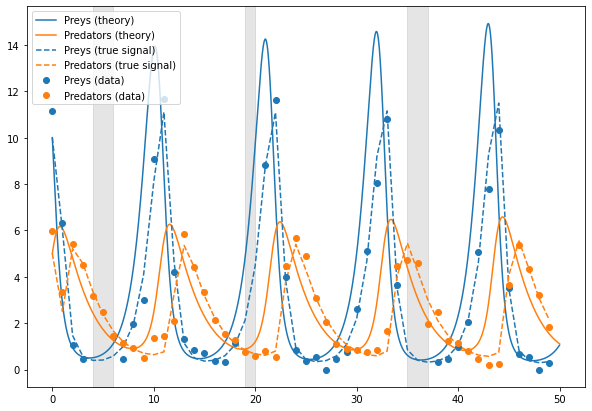

In [5]:
# Plot the theory, signal, and data
plt.figure(figsize=(10,7))
plt.plot(t,Rtheory,label="Preys (theory)")
plt.plot(t,Ftheory,label="Predators (theory)")
plt.plot(np.arange(tmax),Rtsignal,ls="--",color="C0",label="Preys (true signal)")
plt.plot(np.arange(tmax),Ftsignal,ls="--",color="C1",label="Predators (true signal)")
plt.plot(Robs,Rdata,marker="o",ls="",color="C0",label="Preys (data)")
plt.plot(Fobs,Fdata,marker="o",ls="",color="C1",label="Predators (data)")
ymin, ymax = plt.ylim()
for i in range(len(masks)):
    plt.fill_between(masks[i],np.ones_like(masks[i])*ymin,np.ones_like(masks[i])*ymax,color="C7",alpha=0.2)
plt.ylim(ymin,ymax)
plt.legend(loc="best")
plt.show()

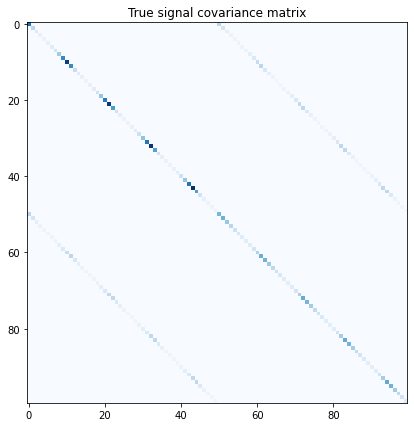

In [6]:
# Check model for the covariance matrix
N=LVo.noise_cov(R=0.05, S=0.005, T=5)
plt.figure(figsize=(7,7))
plt.imshow(np.log(1+N),cmap="Blues")
plt.title("True signal covariance matrix")
plt.show()

## Expansion point: theory and signal

In [7]:
# Expansion values
alpha, beta, gamma, delta = 1.12, 0.45, 0.5, 0.09

# Define simulator instance
LVe = LVsimulator(R0, F0, alpha, beta, gamma, delta)

# Solve the ODEs for the expansion values to find the expansion function
Rthexp, Fthexp = LVe.EEuler(t)

# Simulate observations of the expansion function
Rexp=np.array([Rthexp[tres*n] for n in range(tmax)])
Fexp=np.array([Fthexp[tres*n] for n in range(tmax)])

# Define observer instance and compute signal at the expansion point
LVs = LVobserver(Rexp, Fexp, R0=R0, F0=F0)
Rssignal, Fssignal = LVo.signal(Rexp, Fexp, np.arange(tmax), P=0.08, Q=0.05)

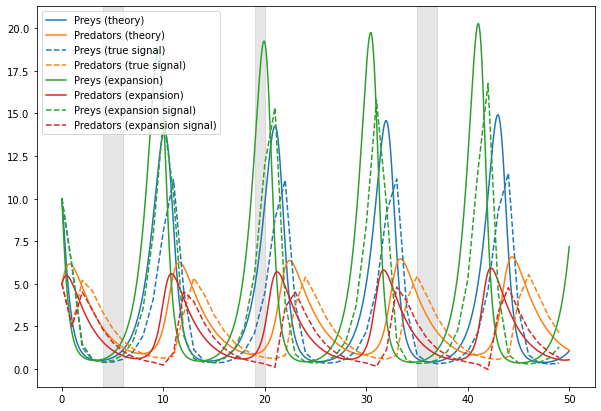

In [8]:
# Plot the expansion function
plt.figure(figsize=(10,7))
plt.plot(t,Rtheory,label="Preys (theory)")
plt.plot(t,Ftheory,label="Predators (theory)")
plt.plot(np.arange(tmax),Rtsignal,ls="--",color="C0",label="Preys (true signal)")
plt.plot(np.arange(tmax),Ftsignal,ls="--",color="C1",label="Predators (true signal)")
plt.plot(t,Rthexp,label="Preys (expansion)")
plt.plot(t,Fthexp,label="Predators (expansion)")
plt.plot(np.arange(tmax),Rssignal,ls="--",color="C2",label="Preys (expansion signal)")
plt.plot(np.arange(tmax),Fssignal,ls="--",color="C3",label="Predators (expansion signal)")
ymin, ymax = plt.ylim()
for i in range(len(masks)):
    plt.fill_between(masks[i],np.ones_like(masks[i])*ymin,np.ones_like(masks[i])*ymax,color="C7",alpha=0.2)
plt.ylim(ymin,ymax)
plt.legend(loc="best")
plt.show()

## Simulations at the expansion point

In [9]:
# Run a batch of simulations
sims = []
sims_ms = []

Nsims=200
for sim in range(Nsims):
    LVs.observe(R0=R0, F0=F0, tmax=tmax, threshold=12, mask=mask, P=0.08, Q=0.05, R=0.05, S=0.005, T=5)
    Robs, Rsim, Fobs, Fsim = LVs.Robs, LVs.Rdata, LVs.Fobs, LVs.Fdata
    sims.append(np.concatenate([Rsim,Fsim]))
    
    LVs.misspecified_observe(R0=R0, F0=F0, tmax=tmax, mask=mask, R=0.04)
    Robs, Rsim_ms, Fobs, Fsim_ms = LVs.Robs, LVs.Rdata, LVs.Fobs, LVs.Fdata
    sims_ms.append(np.concatenate([Rsim_ms,Fsim_ms]))
    
sims=np.array(sims)
sims_ms=np.array(sims_ms)

Rsims_mean=np.mean(sims,axis=0)[0:len(Robs)]
Rsims_std=np.std(sims,axis=0)[0:len(Robs)]
Fsims_mean=np.mean(sims,axis=0)[len(Robs):len(Robs)+len(Fobs)]
Fsims_std=np.std(sims,axis=0)[len(Robs):len(Robs)+len(Fobs)]
Rsims_ms_mean=np.mean(sims_ms,axis=0)[0:len(Robs)]
Rsims_ms_std=np.std(sims_ms,axis=0)[0:len(Robs)]
Fsims_ms_mean=np.mean(sims_ms,axis=0)[len(Robs):len(Robs)+len(Fobs)]
Fsims_ms_std=np.std(sims_ms,axis=0)[len(Robs):len(Robs)+len(Fobs)]

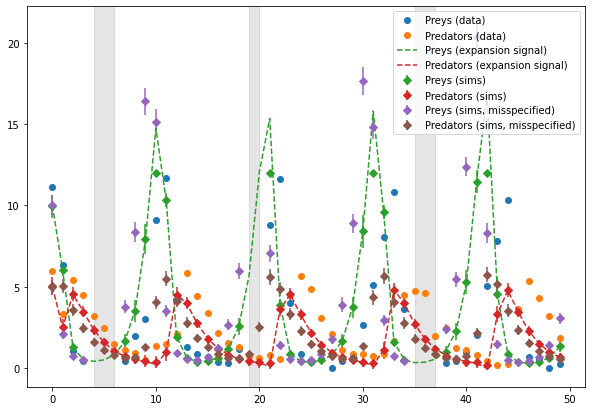

In [10]:
# Plot simulations using correct and misspecified data models
plt.figure(figsize=(10,7))
plt.plot(Robs,Rdata,marker="o",ls="",color="C0",label="Preys (data)")
plt.plot(Fobs,Fdata,marker="o",ls="",color="C1",label="Predators (data)")
plt.plot(np.arange(tmax),Rssignal,ls="--",color="C2",label="Preys (expansion signal)")
plt.plot(np.arange(tmax),Fssignal,ls="--",color="C3",label="Predators (expansion signal)")
plt.errorbar(Robs,Rsims_mean,Rsims_std,marker="D",ls="",color="C2",label="Preys (sims)")
plt.errorbar(Fobs,Fsims_mean,Fsims_std,marker="D",ls="",color="C3",label="Predators (sims)")
plt.errorbar(Robs,Rsims_ms_mean,Rsims_ms_std,marker="D",ls="",color="C4",label="Preys (sims, misspecified)")
plt.errorbar(Fobs,Fsims_ms_mean,Fsims_ms_std,marker="D",ls="",color="C5",label="Predators (sims, misspecified)")
ymin, ymax = plt.ylim()
for i in range(len(masks)):
    plt.fill_between(masks[i],np.ones_like(masks[i])*ymin,np.ones_like(masks[i])*ymax,color="C7",alpha=0.2)
plt.ylim(ymin,ymax)
plt.legend(loc="best")
plt.show()

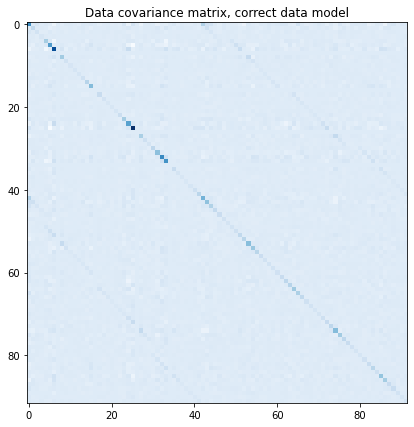

In [11]:
plt.figure(figsize=(7,7))
plt.imshow(np.log(1+np.cov(sims.T)),cmap="Blues")
plt.title("Data covariance matrix, correct data model")
plt.show()

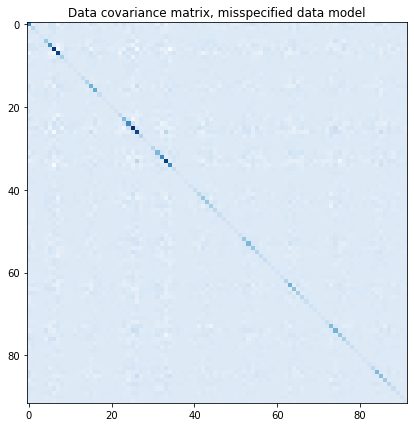

In [12]:
plt.figure(figsize=(7,7))
plt.imshow(np.log(1+np.cov(sims_ms.T)),cmap="Blues")
plt.title("Data covariance matrix, misspecified data model")
plt.show()

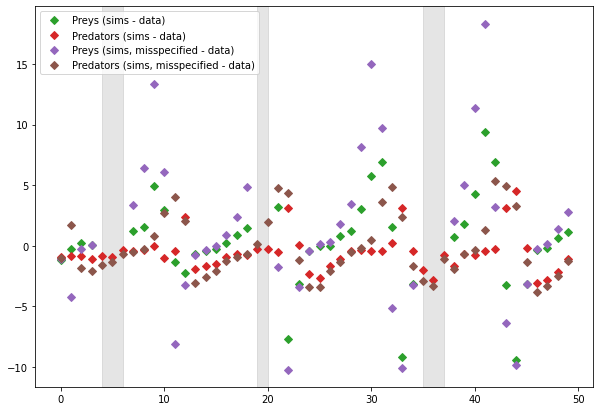

In [13]:
# Plot residuals
plt.figure(figsize=(10,7))
plt.plot(Robs,Rsims_mean-Rdata,marker="D",ls="",color="C2",label="Preys (sims - data)")
plt.plot(Fobs,Fsims_mean-Fdata,marker="D",ls="",color="C3",label="Predators (sims - data)")
plt.plot(Robs,Rsims_ms_mean-Rdata,marker="D",ls="",color="C4",label="Preys (sims, misspecified - data)")
plt.plot(Fobs,Fsims_ms_mean-Fdata,marker="D",ls="",color="C5",label="Predators (sims, misspecified - data)")
ymin, ymax = plt.ylim()
for i in range(len(masks)):
    plt.fill_between(masks[i],np.ones_like(masks[i])*ymin,np.ones_like(masks[i])*ymax,color="C7",alpha=0.2)
plt.ylim(ymin,ymax)
plt.legend(loc="best")
plt.show()